# Testing Mitiq ZNE in OpenQAOA

## Creation of the graph + QUBO model

In [1]:
def create_graph(nodes,edges):
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
    return graph

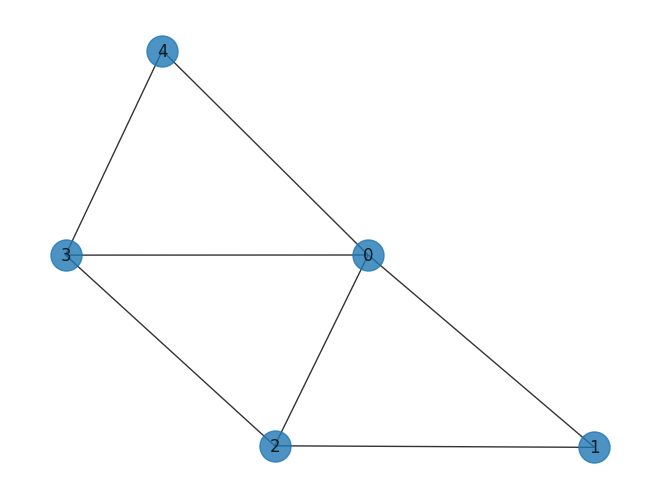

In [2]:
import networkx as nx
from openqaoa.problems import MaximumCut

G = create_graph(
[0, 1, 2, 3, 4, ],
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (3, 4)] 
)

#Inner OpenQAOA function for ploting graphs
#plot_graph(graph)

# Create a MaximumCut instance from the graph and get its QUBO and hamiltonian
maxcut_prob = MaximumCut(G)
maxcut_qubo = maxcut_prob.qubo
maxcut_hamiltonian = maxcut_qubo.hamiltonian

## Creation of the QAOA + Mitiq ZNE class

In [68]:
from openqaoa import QAOA  
q = QAOA()
q

In [69]:
from openqaoa.backends import create_device

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q.set_device(qiskit_device)




## Adding a noise model

## Requesting Mitiq ZNE mitigation and compiling

In [70]:
q.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
noise_model = add_depolarizing_error(NoiseModel(),0.3)
q.set_circuit_properties(p=2)

q.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)
q.compile(maxcut_qubo)

## Optimization

In [71]:
q.optimize()

## Getting the solution

In [72]:
from openqaoa.utilities import ground_state_hamiltonian
correct_solution = ground_state_hamiltonian(q.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

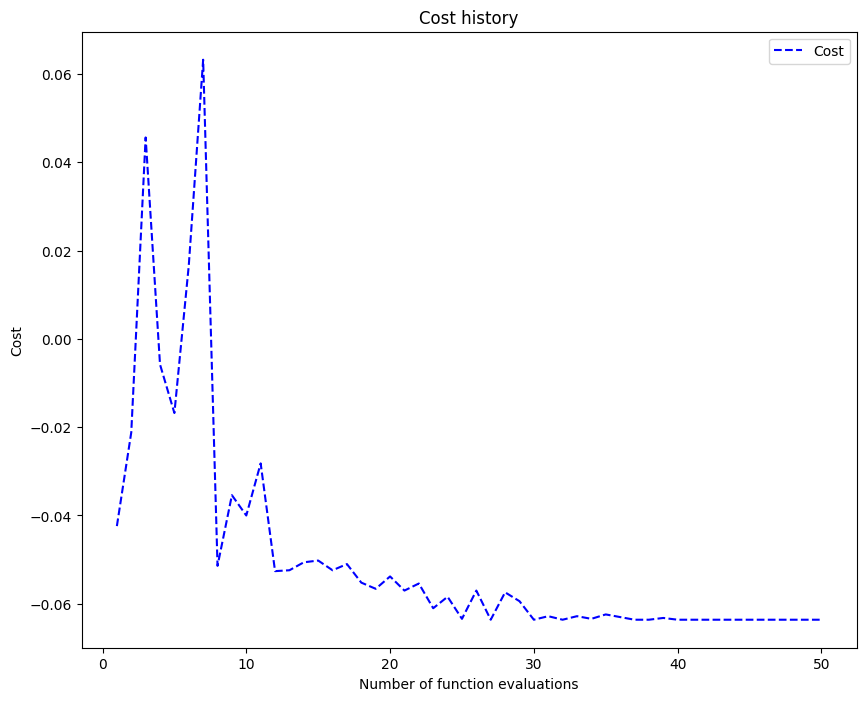

In [73]:
opt_results = q.result
opt_results.plot_cost()


## Comparing with standard QAOA, with noise

In [64]:
q1 = QAOA()
q1.set_device(qiskit_device)

from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.3)
q1.set_circuit_properties(p=2)
q1.set_backend_properties(n_shots=10000, seed_simulator=1, noise_model = noise_model)

""" q1.set_backend_properties(n_shots=1024, seed_simulator=1, noise_model = noise_model) """

q1.compile(maxcut_qubo)

In [65]:
q1.optimize()

In [66]:
correct_solution = ground_state_hamiltonian(q1.cost_hamil)
correct_solution

(-3.0,
 ['10100', '10010', '01010', '11010', '00101', '10101', '01101', '01011'])

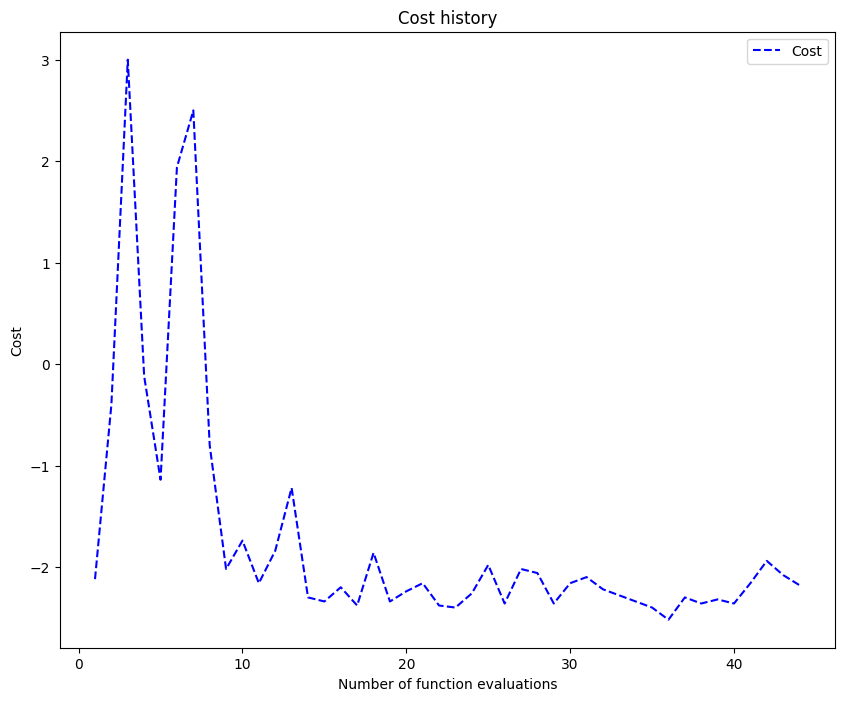

In [67]:
opt_results = q1.result
opt_results.plot_cost()

## Comparing with standard QAOA, with IBM Quantum backend

In [5]:
from qiskit import IBMQ
from openqaoa import create_device
from qiskit_ibm_provider import IBMProvider

In [36]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
ibm_device = create_device(location='ibmq', 
                                name='ibm_osaka',
                                hub='ibm-q', 
                                group='open', 
                                project='main')

In [14]:
q2 = QAOA()
q2.set_device(ibm_device)
q2.compile(maxcut_qubo)

In [15]:
q2.optimize()

KeyboardInterrupt: 

In [ ]:
correct_solution = ground_state_hamiltonian(q2.cost_hamil)
correct_solution

## Comparing with OpenQAOA + Mitiq ZNE, with IBM Quantum backend

In [7]:
q3 = QAOA()
q3.set_device(ibm_device)
q3.set_backend_properties(n_shots=1024, seed_simulator=1)
q3.set_error_mitigation_properties(
    error_mitigation_technique='mitiq_zne',n_batches=4,calibration_data_location="caldata.json"
)
q3.compile(maxcut_qubo)

In [8]:
q3.optimize()

TranspilerError: "The number of qubits for Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

In [ ]:
correct_solution = ground_state_hamiltonian(q3.cost_hamil)
correct_solution

In [8]:
from openqaoa.backends.qaoa_backend import (
    DEVICE_NAME_TO_OBJECT_MAPPER,
    DEVICE_ACCESS_OBJECT_MAPPER,
)

In [9]:
print(DEVICE_NAME_TO_OBJECT_MAPPER.keys())

dict_keys(['vectorized', 'analytical_simulator', 'qiskit.qasm_simulator', 'qiskit.shot_simulator', 'qiskit.statevector_simulator'])
